In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
import matplotlib.pyplot as plt

In [2]:
# Load your data
#data1 = pd.read_csv("feature_engineered_data.csv")
data1=pd.read_csv("ml_model_data.csv")

 # Column indices are 0-based in pandas
target = data1['Surf_length']

In [3]:
# Select input features and target feature
features = data1.iloc[:, [1,6,8,11,13,]] 

In [4]:
features

,DOD_SOL,SIL_MOL,MOL_NAN,d_DOD_SIL,rdf_dist
0,-3015.193959,-1724.537763,-756.148356,-18.780941,3.570
1,-3188.197113,-1526.882049,-301.895760,-1.257190,3.706
2,-2830.234950,-1618.940756,-531.670610,0.593097,3.556
3,-3237.448726,-2005.260598,-259.779031,-28.234922,3.322
4,-2884.037610,-1533.482469,-210.237799,-16.113649,3.578
...,...,...,...,...,...
95,-3360.543947,19052.052850,-2224.967016,91.755774,0.480
96,-3245.969782,19035.908660,-2141.296944,82.755312,0.488
97,-3224.705503,19111.903010,-1.044720,163.559421,0.490
98,-3296.660481,19095.507030,-44.839519,104.653614,0.484


In [5]:
print(target.head())

0    3
1    3
2    3
3    3
4    3
Name: Surf_length, dtype: int64


In [6]:
# Perform Robust Scaling
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.1, random_state=196)


In [8]:
# Define the Ridge regression model
ridge = Ridge(random_state=196)

# Perform grid search for regularization strength using GridSearchCV
param_grid = {'alpha': np.logspace(-4, 4, 50)}  # Search across a wide range of alpha values
grid_search = GridSearchCV(ridge, param_grid, cv=5)
grid_search.fit(X_train, y_train)
# Print the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'alpha': 0.8286427728546842}


In [9]:
# Function to perform K-Fold cross-validation and calculate average R-squared
def kfold_avg_r2(n_splits, X_train, y_train):
    model = Ridge(
        alpha=best_params['alpha'],
        random_state=196  # Ensure consistent results
    )
    scores = []
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=196)
    for train_index, val_index in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        scores.append(r2_score(y_val_fold, y_pred_fold))
    return np.mean(scores)

# Find the number of K-folds with the best average R-squared
best_n_splits = None
best_avg_r2 = 0
avg_r2_scores = []

for n_splits in range(2, 20):
    avg_r2 = kfold_avg_r2(n_splits, X_train, y_train)
    avg_r2_scores.append(avg_r2)
    if avg_r2 > best_avg_r2:
        best_n_splits = n_splits
        best_avg_r2 = avg_r2

print(f"Best number of K-fold splits: {best_n_splits}")
print(f"Best K-fold R-squared score: {best_avg_r2:.4f}")

Best number of K-fold splits: 6
Best K-fold R-squared score: 0.5053


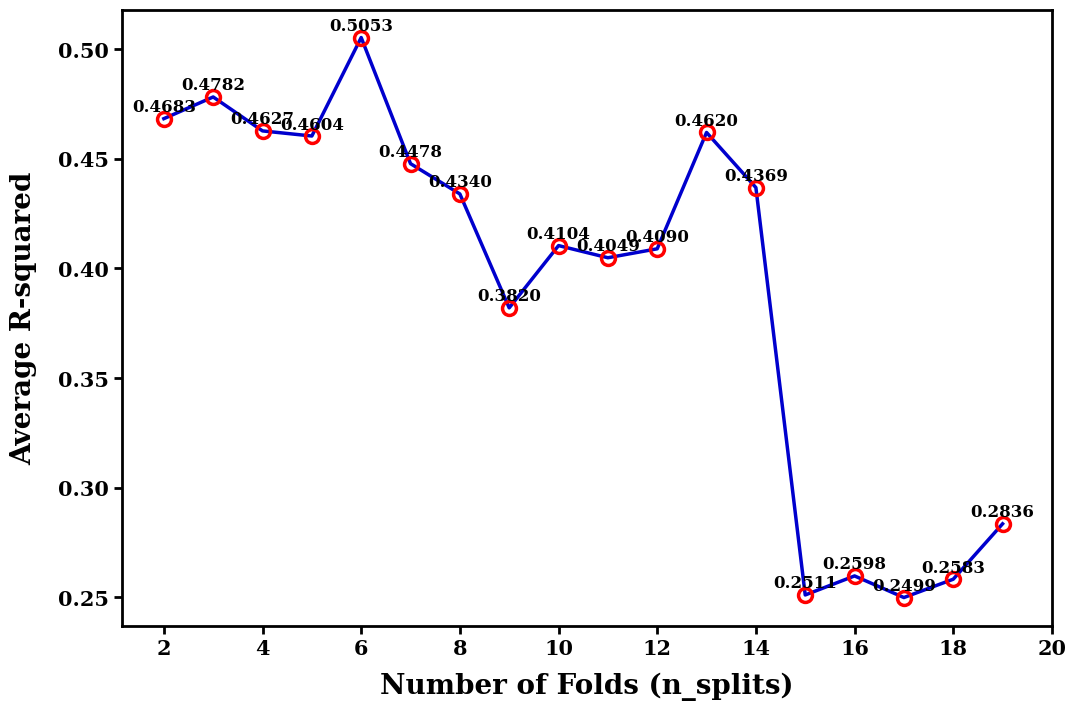

In [10]:
# Plot average R-squared vs. number of folds
plt.figure(figsize=(12, 8))  # Optional: to make the plot larger
plt.plot(range(2, 20), avg_r2_scores, marker='o', lw=2.5,color='mediumblue', markersize=10, markerfacecolor='none', markeredgecolor='red', markeredgewidth=2.5)
plt.xlabel("Number of Folds (n_splits)", fontname='serif', fontsize=20, fontweight='bold', labelpad=10)
plt.ylabel("Average R-squared", fontname='serif', fontsize=20, fontweight='bold', labelpad=15)
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20], fontname='serif', fontsize=15, fontweight='bold')
plt.yticks(fontname='serif', fontsize=15, fontweight='bold')
#plt.grid(True)

# Annotate each point with its R-squared value
for i, txt in enumerate(avg_r2_scores):
    plt.annotate(f'{txt:.4f}', (i + 2, avg_r2_scores[i]), textcoords="offset points", 
                 xytext=(0, 5), ha='center', fontsize=12, fontname='serif', fontweight='bold')  # Increased fontsize


border_width = 2  # Set the border width
tick_width = 2  # Set the tick-line width

# Customize spines (border) and ticks
for spine in plt.gca().spines.values():
    spine.set_linewidth(border_width)

# Increase the thickness of x-axis ticks
plt.tick_params(axis='x', which='both', direction='out', length=6, width=2)

# Increase the thickness of y-axis ticks
plt.tick_params(axis='y', which='both', direction='out', length=6, width=2)

plt.savefig('n_split_variation_ridge_regression.png', dpi = 350, bbox_inches='tight')

In [11]:
# Perform K-fold cross-validation with the best number of splits and print error metrics
best_ridge = Ridge(alpha=best_params['alpha'], random_state=196)

In [12]:
from sklearn.metrics import make_scorer
# Define a custom MBE function
def mbe(y_true, y_pred):
    return np.mean(y_pred - y_true)

# Create a scorer for MBE
mbe_scorer = make_scorer(mbe)

kf = KFold(n_splits=best_n_splits, random_state=196, shuffle=True)
r2_scores = cross_val_score(best_ridge, X_train, y_train, cv=kf, scoring='r2')
mse_scores = -cross_val_score(best_ridge, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
mae_scores = -cross_val_score(best_ridge, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
ev_scores = cross_val_score(best_ridge, X_train, y_train, cv=kf, scoring='explained_variance')
# Calculate MBE using the custom scorer
mbe_scores = cross_val_score(best_ridge, X_train, y_train, cv=kf, scoring=mbe_scorer)
# Calculate RMSE scores
rmse_scores = np.sqrt(mse_scores)


In [13]:
print(f"K-fold R-squared scores: {r2_scores}")
print(f"K-fold Mean R-squared: {np.mean(r2_scores):.4f}")
print(f"K-fold Mean Squared Error scores: {mse_scores}")
print(f"K-fold Mean MSE: {np.mean(mse_scores):.4f}")
print(f"K-fold Mean Absolute Error scores: {mae_scores}")
print(f"K-fold Mean MAE: {np.mean(mae_scores):.4f}")
print(f"K-fold Explained Variance scores: {ev_scores}")
print(f"K-fold Mean Explained Variance: {np.mean(ev_scores):.4f}")
print(f'RMSE scores: {rmse_scores}')
print(f"Average K-Fold RMSE: {np.mean(rmse_scores):.4f}")
print(f"MBE Scores: {mbe_scores}")
print(f"Average MBE Scores: {np.mean(mbe_scores):.4f}")

K-fold R-squared scores: [0.50227546 0.55765648 0.473525   0.36781694 0.74629214 0.38431809]
K-fold Mean R-squared: 0.5053
K-fold Mean Squared Error scores: [0.6105421  0.58192748 0.59433178 0.65747038 0.29768389 0.69503647]
K-fold Mean MSE: 0.5728
K-fold Mean Absolute Error scores: [0.57792472 0.57549132 0.62232968 0.56999096 0.49242342 0.66801916]
K-fold Mean MAE: 0.5844
K-fold Explained Variance scores: [0.50820568 0.5583625  0.47993967 0.37987971 0.74686153 0.47748849]
K-fold Mean Explained Variance: 0.5251
RMSE scores: [0.78137193 0.76284171 0.77092917 0.81084547 0.54560416 0.83368847]
Average K-Fold RMSE: 0.7509
MBE Scores: [ 0.08529007  0.03047639  0.08509669  0.11200572  0.0258474  -0.32431318]
Average MBE Scores: 0.0024


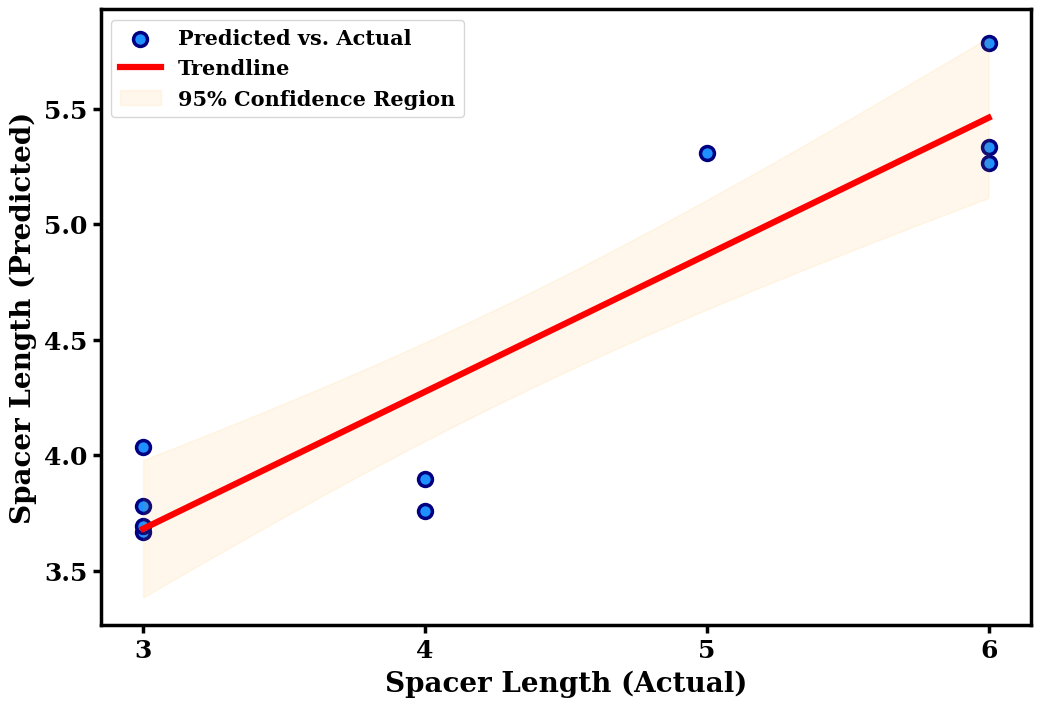

In [14]:
# Train the final model on the entire training data
best_ridge.fit(X_train, y_train)
# Make predictions on the test set
y_pred = best_ridge.predict(X_test)
rounded_y_pred = np.round(y_pred)
# Calculate the trendline
slope, intercept = np.polyfit(y_test, y_pred, 1)  # Linear trendline

# Generate x values for the trendline (adjust number of points for smoother line)
x_trend = np.linspace(min(y_test), max(y_test), 100)
y_trend = slope * x_trend + intercept

# Calculate the 95% confidence interval
p = np.polyfit(y_test, y_pred, 1)
yfit = np.polyval(p, y_test)
yerr = y_pred - yfit
mean_x = np.mean(y_test)
n = len(y_test)
t_val = 1.96  # Approximate value for 95% confidence
s_err = np.sum(np.power(yerr, 2))
conf = t_val * np.sqrt((s_err / (n - 2)) * (1.0/n + (np.power((x_trend - mean_x), 2) / ((np.sum(np.power(y_test, 2))) - n*(mean_x**2)))))

# Create the plot
plt.figure(figsize=(12, 8)) 
plt.scatter(y_test, y_pred, edgecolor='navy', facecolors='dodgerblue', alpha=1.0, label="Predicted vs. Actual", marker='o', s=100, linewidth=2.5)

plt.plot(x_trend, y_trend, color="red", label="Trendline", lw=4.5)

# Plot the confidence interval
plt.fill_between(x_trend, y_trend - conf, y_trend + conf, color='orange', alpha=0.08, label="95% Confidence Region")

# Labels and title
plt.xlabel("Spacer Length (Actual)", fontname='serif', fontsize=20, fontweight='bold', labelpad=5)
plt.ylabel("Spacer Length (Predicted)", fontname='serif', fontsize=20, fontweight='bold', labelpad=5)

# Customize legend
plt.legend(prop={'family': 'serif', 'size': 15, 'weight': 'bold'})

# Grid and show the plot
#plt.tight_layout()

border_width = 2.5  # Set the border width
tick_width = 2.5  # Set the tick-line width

# Customize spines (border) and ticks
for spine in plt.gca().spines.values():
    spine.set_linewidth(border_width)
plt.xticks([3,4,5,6],fontname='serif', fontsize=18, fontweight='bold')
plt.yticks(fontname='serif', fontsize=18, fontweight='bold')
# Increase the thickness of x-axis ticks
plt.tick_params(axis='x', which='both', direction='out', length=6, width=2.5)

# Increase the thickness of y-axis ticks
plt.tick_params(axis='y', which='both', direction='out', length=6, width=2.5)
plt.savefig('pred_vs_actual_plot_ridge_regression.png', dpi=350)

In [17]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate other metrics (assuming you already have the code)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)
mbe = np.mean(y_pred - y_test)

# Print the metrics
print(f'Test R-squared: {r2:.4f}')
print(f'Test Mean Squared Error: {mse:.4f}')
print(f'Test Root Mean Squared Error: {rmse:.4f}')  # Added this line
print(f'Test Mean Absolute Error: {mae:.4f}')
print(f'Test Explained Variance: {explained_variance:.4f}')
print(f'Test Mean Bias Error: {mbe:.4f}') 

Test R-squared: 0.7645
Test Mean Squared Error: 0.3792
Test Root Mean Squared Error: 0.6158
Test Mean Absolute Error: 0.5438
Test Explained Variance: 0.7790
Test Mean Bias Error: 0.1530


In [18]:
# Create a DataFrame to store y_test, y_pred, and rounded y_pred
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
    'y_pred_rounded': np.round(y_pred)
})


# Save the DataFrame to a CSV file
results_df.to_csv("ridge_regression_predictions.csv", index=False)